# <center> Million Songs Analysis</center>

## Starting the Spark session

In [1]:
from pyspark.sql import SparkSession

spark_session = SparkSession\
        .builder\
        .master("spark://host-192-168-1-153-ldsa:7077")\
        .appName("Project_19")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","60m")\
        .config("spark.dynamicAllocation.minExecutors", 1)\
        .config("spark.dynamicAllocation.maxExecutors", 4)\
        .config("spark.executor.cores",8)\
        .getOrCreate()

spark_context = spark_session.sparkContext

## Importations

In [2]:
import h5py
import io, time
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.types import *


## Functions

In [3]:
""" This function returns the song information in a visible way (as a string) """
def song_str(song) :
    if song["year"] != 0 :
        return "{} - {} ({})".format(song["title"], song["artist_name"], song["year"])
    else :
        return "{} - {}".format(song["title"], song["artist_name"])

In [4]:
""" This function asks the user for the title of a song and returns it from the database """
def ask_for_song() :
    right = False # Boolean to verify that the user's song is the one found in the database   
    while not right : 
        song_title = input(" Title of the song : ")
        # We look at the song in the database even if the user enters an incomplete name
        song = df_songs.filter(df_songs["title"].like("%" + song_title + "%")).first()
        while song == None :
            print(" This song doesn't exist in the database")
            song = df_songs.filter(df_songs["title"].like("%" + input("Title of the song : ") + "%")).first()
        right = (input(" Is your song {} (y/n) ? ".format(song_str(song))) == 'y')
    
    print(" The chosen song is : {} ".format(song_str(song)))
    return song

In [5]:
""" This function asks the user for the values of the attributes (tempo, loudness, hotness, danceability) """
def ask_for_margins() :
    margins = {}
    print("\nEnter the values of the margins you want to consider for the song attributes (tempo, loudness,\
    hotness, danceability). \n\nYou can enter '*' to skip the attribute and not take it into consideration.\n ")
    
    list_names = ["tempo", "loudness", "hotness", "danceability"]
    for att in list_names :
        print("{} : ".format(att))
        att_margin = input("\t - margin (Enter * to skip): ")
        if att_margin == "*" :
            margins[att] = (100, 0)
        else :
            att_margin_increase = input("\t - the margin's increase each step : ")
            margins[att] = (float(att_margin), float(att_margin_increase))
            
    return margins

In [6]:
""" This function returns the songs which belong to the same artist as the input song(Row) """
def same_artist(song) :
    similar_songs = df_songs.filter(df_songs.artist_name == song["artist_name"])
    return similar_songs.filter(similar_songs.title != song["title"])
  

In [7]:
""" This function returns the songs, from the dataframe, which have similar tempo as the input song"""
def similar_tempo(song, dataframe, margin) : 
    similar_songs = dataframe.filter(dataframe.tempo.between(song["tempo"] - margin, song["tempo"] + margin))\
                             .filter(dataframe.title != song["title"])
 
    return similar_songs

In [8]:
""" This function returns the songs, from the dataframe, which have similar loudness as the input song """
def similar_loudness(song, dataframe, margin) : 
    similar_songs = dataframe.filter(dataframe.loudness.between(song["loudness"] - margin, song["loudness"] + margin))\
                             .filter(dataframe.title != song["title"])

    return similar_songs

In [9]:
""" This function returns the songs, from the dataframe, which have similar hotness as the input song """
def similar_hotness(song, dataframe, margin) : 
    similar_songs = dataframe.filter(dataframe.hotness.between(song["hotness"] - margin, song["hotness"] + margin))\
                             .filter(dataframe.title != song["title"])

    return similar_songs

In [10]:
""" This function returns the songs, from the dataframe, which have similar danceability as the input song """
def similar_danceability(song, dataframe, margin) : 
    similar_songs = dataframe.filter(dataframe.danceability.between(song["danceability"] - margin, song["danceability"] + margin))\
                             .filter(dataframe.title != song["title"])

    return similar_songs

In [11]:
""" This function returns the songs, from the dataframe, which are similar to the input song based on tempo, loudness,
hotness and danceability """
# number is the number of generated suggestions
# margins is a dictionary with the 4 attributes above as keys and their corresponding values are a tuple of
# (initial margin, margin_increase)
def similar_model1(song, number, margins) :
    similar_songs = spark_session.createDataFrame(spark_context.emptyRDD(), songs_schema).cache()
    x, num_iter = 0, 0
    max_iterations = 200
    while similar_songs.count() < number and num_iter < max_iterations :
        similar_songs_inter = similar_tempo(song, df_songs, margins["tempo"][1] * x + margins["tempo"][0])
        similar_songs_inter = similar_loudness(song, similar_songs_inter, margins["loudness"][1] * x + margins["loudness"][0])
        similar_songs_inter = similar_danceability(song, similar_songs_inter, margins["hotness"][1] * x + margins["hotness"][0])
        similar_songs = similar_hotness(song, similar_songs_inter, margins["danceability"][1] * x + margins["danceability"][0])
        x += 1
        num_iter +=1
    return similar_songs.limit(number)

## Loading the data into RDDs  (Skip and go directly to loading data frames from CSV files)

In [ ]:
""" This function turns a list of binary elements to a string with the element separated by the character ',' """
def list_bin_to_str(list_terms) :
    string=""
    for term in list_terms :
        string += term.decode()+','
    return string[1:-1]   

In [ ]:
""" We prepare first a RDD containing tuples (song_information, artist_information) """
#rdd = spark_context.binaryFiles("hdfs://host-192-168-1-153-ldsa:9000/millionsongs/data/A/B/*")
rdd = spark_context.binaryFiles("/mnt/ms/data/*/*/*")

# A function to open the h5 files one by one and take the information of interest for the song and the artist
def f(x):
    with h5py.File(io.BytesIO(x[1])) as f:
        
        f_meta = f['metadata']["songs"]
        f_analys = f['analysis']["songs"]
        f_brainz = f['musicbrainz']["songs"]
        
        artist_terms = list_bin_to_str(f['metadata']['artist_terms'][:10])
        similar_artists = list_bin_to_str(f['metadata']['similar_artists'][:10])
        
        return ((f_meta[0][-3].decode(), f_meta[0][-2].decode(),
                f_meta[0][9].decode(), f_meta[0][4].decode(),
                f_meta[0][-6].decode(),
                float(f_analys[0][3]), float(f_meta[0][-4]),
                float(f_analys[0][2]), float(f_analys[0][23]), 
                float(f_analys[0][-4]), int(f_brainz[0][1])), 
               
                (f_meta[0][4].decode(), f_meta[0][9].decode(),
                f_meta[0][6].decode(), float(f_meta[0][3]),
                artist_terms, similar_artists))

rdd = rdd.map(f)

""" We create two RDDs (songs, artists) from the general one """
rdd_songs = rdd.map(lambda x : x[0])
rdd_artists = rdd.map(lambda x : x[1])

## Turning RDDs to Data frames (Skip and go directly to load data frames from CSV files)

<b> *   Table Songs </b>

In [ ]:
attributes = rdd_songs.map(lambda p: Row(p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10]))
fields = [StructField("song_id", StringType(), True), StructField("title", StringType(), True), 
          StructField("artist_name", StringType(), True), StructField("artist_id", StringType(), True),
          StructField("release_album", StringType(), True), 
          StructField("duration", FloatType(), True), StructField("hotness", FloatType(), True), 
          StructField("danceability", FloatType(), True), StructField("loudness", FloatType(), True), 
          StructField("tempo", FloatType(), True), StructField("year", IntegerType())]
songs_schema = StructType(fields)

df_songs = spark_session.createDataFrame(attributes, songs_schema)
df_songs.show()

<b> *   Table Artists </b>

In [ ]:
attributes = rdd_artists.map(lambda p: Row(p[0], p[1], p[2], p[3], p[4], p[5]))
fields = [StructField("id", StringType(), True), StructField("name", StringType(), True), 
          StructField("location", StringType(), True), StructField("hotness", FloatType(), True),
          StructField("terms", StringType(), True), 
          StructField("similar_artists", StringType(), True)]
artists_schema = StructType(fields)

df_artists = spark_session.createDataFrame(attributes, artists_schema)
df_artists.show()

## Saving data frames in csv files (Skip and go directly to load data frames from CSV files)

<b> *   Table Songs </b>

In [ ]:
df_songs.write.format('com.databricks.spark.csv')\
        .option("header", "true")\
        .save('/home/ubuntu/AllsongsB.csv')


<b> *   Table Artists </b>

In [ ]:
df_artists.write.format('com.databricks.spark.csv')\
        .option("header", "true")\
        .save('/home/ubuntu/MyArtists_all.csv')

## Loading data frames from csv files

<b> *   Table Songs </b>

 <font size="3"> Lets take a look at the table : </font> 

In [16]:
fields = [StructField("song_id", StringType(), True), StructField("title", StringType(), True), 
          StructField("artist_name", StringType(), True), StructField("artist_id", StringType(), True),
          StructField("release_album", StringType(), True), 
          StructField("duration", FloatType(), True), StructField("hotness", FloatType(), True), 
          StructField("danceability", FloatType(), True), StructField("loudness", FloatType(), True), 
          StructField("tempo", FloatType(), True), StructField("year", IntegerType())]
songs_schema = StructType(fields)

df_songs = spark_session.read.csv("hdfs://192.168.1.153:9000/team19/AllsongsB.csv",
                                  header = True,
                                  schema= songs_schema)\
                        .union(spark_session.read.csv("hdfs://192.168.1.153:9000/team19/MySongs_all.csv",
                                  header = True,
                                  schema= songs_schema))\
                        .cache()
    

df_songs.limit(10).show()

+------------------+--------------------+---------------+------------------+--------------------+---------+----------+------------+--------+-------+----+
|           song_id|               title|    artist_name|         artist_id|       release_album| duration|   hotness|danceability|loudness|  tempo|year|
+------------------+--------------------+---------------+------------------+--------------------+---------+----------+------------+--------+-------+----+
|SOJDNCH12A8C14022C|       Suburban Life| Static Thought|ARHUXXU1187FB3EA9E|The Motive For Mo...|164.28363|       0.0|         0.0|  -4.305| 196.43|   0|
|SOFMTVM12A8C131323|God Rest Ye Merry...|     Perry Como|ARX5KSY1187FB3CBDC| The Christmas Album|176.90077|       NaN|         0.0| -17.531| 64.438|   0|
|SOWAWNL12A67AE2071|  Can´t Be Satisfied|Abi Wallenstein|ARL82QM1187FB4C21A|  Good Morning Blues|354.19382|       0.0|         0.0| -13.942|111.967|   0|
|SOANTBR12AB0188517|             Duermen|      Tote King|AR7QU981187FB557A2|

<b> *   Table Artists </b>

<font size="3"> Lets take a look at this table as well : </font>   

In [19]:
fields = [StructField("id", StringType(), True), StructField("name", StringType(), True), 
          StructField("location", StringType(), True), StructField("hotness", FloatType(), True),
          StructField("terms", StringType(), True), 
          StructField("similar_artists", StringType(), True)]
artists_schema = StructType(fields)

df_artists = spark_session.read.csv("hdfs://192.168.1.153:9000/team19/MyArtists_all.csv",
                                  header = True,
                                  schema= artists_schema)\
                          .cache()

df_artists.limit(10).show()

+------------------+--------------------+--------------------+----------+--------------------+--------------------+
|                id|                name|            location|   hotness|               terms|     similar_artists|
+------------------+--------------------+--------------------+----------+--------------------+--------------------+
|AR9MRSJ1187B99B99F|La Charanga Rubal...|                null|0.21697496|haranga,los angel...|RZ7OD71187B9940A7...|
|ARHE2C01187B99A27E|              Dakota|     California - LA|0.40711004|rogressive house,...|R0ZJD61187FB49CE5...|
|ARG4PVO1187B98BFDF|          Adam Brand|      Hervey Bay QLD| 0.4024891|ountry rock,pop r...|RNAMBH1187B98F6A4...|
|ARIAJDN1187FB4D070|         Pat Martino|    Philadelphia, PA|0.37786224|oul jazz,hard bop...|RFACVS1187B98C226...|
|ARYLG3I119B8668696|Rockin' Dopsie_ J...|                null|       0.0|ydeco,funk,beat,b...|RKJHKX1187FB5AEE5...|
|ARL8EFT1187FB3647C|    Jon Oliva's Pain|                null|0.44557843

## Core Analysis

### Asking the user for a song 

In [20]:
user_song = ask_for_song()

 Title of the song : Rattle
 Is your song Rattlesnake - Rodolphe Burger (2008) (y/n) ? n
 Title of the song : snake
 Is your song Rattlesnake - Rodolphe Burger (2008) (y/n) ? y
 The chosen song is : Rattlesnake - Rodolphe Burger (2008) 


### Songs from the same artist

In [21]:
songs_same_artist = same_artist(user_song)
if songs_same_artist.count() != 0 :
    some_songs = songs_same_artist.take(10)
    print(" Songs from the same artist :")
    for song in some_songs : 
        print(" * ", song["title"])
else :
    print(" This artist doesn't have any other songs.")
    

 Songs from the same artist :
 *  Sing
 *  Elle Est Pas Belle Ma Chérie ?


### Songs with similar tempo

In [23]:
margin = 1
songs_similar_tempo = similar_tempo(user_song, df_songs, margin).limit(10).collect()
if songs_similar_tempo != None :
    print("Songs with similar tempo (with a margin of {}) :".format(margin))
    for song in songs_similar_tempo : 
        print(" * ", end="")
        print(song_str(song))

Songs with similar tempo (with a margin of 1) :
 * Ein Skinhead ohne Stiefel - Loikaemie (1996)
 * Motgångar - Allan Edwall
 * Heart Trouble - Martina McBride (1993)
 * Goin' Home For Christmas - Alabama Red
 * United Races (Album Version) - Cause For Alarm
 * Living The Dream - Umlaut
 * Line Finish (Tunnel Vision Album Version) - Tunnel Rats (2001)
 * Livin' Lovin' Wreck - Shakin' Stevens (1983)
 * Green fields of football - Darko Rundek
 * Loco Enamorado - Los Palominos (1998)


### Songs with similar loudness

In [24]:
margin = 0.1
songs_similar_loudness = similar_loudness(user_song, df_songs, margin).limit(10).collect()
if songs_similar_loudness != None :
    print("Songs with similar loudness (with a margin of {}) :".format(margin))
    for song in songs_similar_loudness : 
        print(" * ", end="")
        print(song_str(song))

Songs with similar loudness (with a margin of 0.1) :
 * Sephardic Secrets - Men's Recovery Project (2000)
 * I Am An Exercise - Pele (1998)
 * Kay - MARTIRES DEL COMPAS (2004)
 * Flight of the Elephant - Workhorse (2007)
 * Liebe vergeht - Mantus
 * Drugs Are For Kids - Doug Stanhope (2002)
 * China - Tori Amos (1992)
 * Limbo Rock - Holly Dolly
 * Telephone Numbers - Corrupted Ideals
 * Only Just Begun - John Holt


### Songs with similar hotness

In [25]:
margin = 0.1
songs_similar_hotness = similar_hotness(user_song, df_songs, margin).limit(10).collect()
if songs_similar_hotness != None :
    print("Songs with similar hotness (with a margin of {}) :".format(margin))
    for song in songs_similar_hotness : 
        print(" * ", end="")
        print(song_str(song))

Songs with similar hotness (with a margin of 0.1) :
 * Hug Me - Forty Winks (2002)
 * Lusco - Berrogüetto
 * War Over Water - Samuel Flynn Scott (2006)
 * The Chase - Jennings
 * Tus Desprecios - Elsa Garcia
 * Don't Wanna Talk About Love - Danielle Brisebois
 * Look What You've Done (Tree63 Album Version) - Tree63 (2001)
 * Stoned love - Ojm (2006)
 * Do My Baby Ever Think Of Me - Fred McDowell
 * Cinderellas Palace - Obscenity Trial (2008)


### Songs with similar danceability

In [26]:
margin = 0.1
songs_similar_danceability = similar_danceability(user_song, df_songs, margin).limit(10).collect()
if songs_similar_danceability != None :
    print("Songs with similar danceability (with a margin of {}) :".format(margin))
    for song in songs_similar_danceability : 
        print(" * ", end="")
        print(song_str(song))

Songs with similar danceability (with a margin of 0.1) :
 * Suburban Life - Static Thought
 * God Rest Ye Merry_ Gentlemen - Perry Como
 * Can´t Be Satisfied - Abi Wallenstein
 * Duermen - Tote King
 * House Music - Save As
 * La Carretera - La Guardia
 * Creole Love Call - Roger Kellaway (1991)
 * Deus Ex Machina - William Orbit (1993)
 * Ti-Am Dat Un Inel - Holograf
 * Hug Me - Forty Winks (2002)


### Songs with similar tempo, loudness, hotness and danceability

In [27]:
margins = {"tempo" : (1, 0.1), "loudness" : (2, 0.4), "hotness" : (29.5, 0), "danceability" : (0.01, 0.00)}

<font size="3"> To make things clearer, lets plot first the margins,  which are going to be passed as an argument to the function below, as a function of the number of iterations : </font>

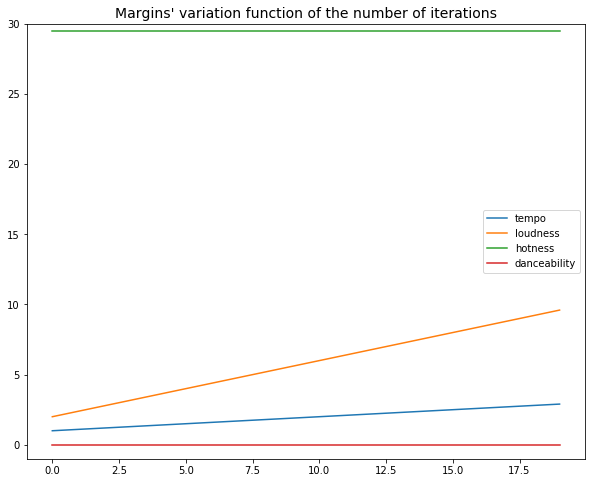

In [29]:
X_iterations = range(20)
Y_margins = [[], [], [], []]

list_margins = [(1,0.1), (2,0.4), (29.5,0), (0.01,0)]
for i in range(20) :
    for j in range(4) :
        Y_margins[j].append(list_margins[j][0] + i * list_margins[j][1])
        
labels = ["tempo", "loudness", "hotness", "danceability"]
plt.figure(figsize=(10,8))
for i in range(4) :
    plt.plot(X_iterations, Y_margins[i], label = labels[i])
plt.ylim(-1,30)
plt.title("Margins' variation function of the number of iterations", {"fontsize" : 14})   
plt.legend()
plt.show()

 <b> <font size="3">Remarks : </font></b>  
<font size="3"> 
- The margins are always getting larger <br>
- The user can ignore an attribute by giving it a large margin (See ’hotness’ in the figure above) <br>

- The user can be strict about the margin of an attribute by choosing a
small value for the corresponding margin increase (See ’danceability’ in
the figure above)
</font>

<font size="3"> Lets take a look now at the result of the previous model </font>

In [30]:
songs_similar_model1 = similar_model1(user_song, 10, margins)
print("Similar songs following the model 1:")
for song in songs_similar_model1.collect() : 
    print(" * ", end="")
    print(song_str(song))

Similar songs following the model 1:
 * Livin' Lovin' Wreck - Shakin' Stevens (1983)
 * Never Been Better - Wax
 * Tyme-N My Life - Richie Rich
 * Ostinada - Tommy Bolin
 * La Cana - Adalberto Santiago (1977)
 * Happy One Step - Savoy-Doucet Cajun Band
 * La Unica - Maelo Ruiz
 * Fake Love (Instrumental) - Statik Selektah
 * All Because Of You - Conya Doss
 * Urgence - Sonia Dersion (2004)


### Main program

In [32]:
user_song = ask_for_song()
margins = ask_for_margins()
#margins ={"tempo" : (0, 0.02), "loudness" : (0, 0.02), "hotness" : (0, 0.02), "danceability" : (0, 0.02)}
number = input(" The number of songs you want to generate : ")

# Generation following the model 1
songs_similar_model1 = similar_model1(user_song, int(number), margins)
print("\nSimilar songs following the model 1 :")
for song in songs_similar_model1.collect() : 
    print(" * ", end="")
    print(song_str(song))

# Other songs from the same artist : 
songs_same_artist = same_artist(user_song)
if songs_same_artist.count() != 0 :
    some_songs = songs_same_artist.take(10)
    print("\nSongs from the same artist :")
    for song in some_songs : 
        print(" * ", song["title"])
else :
    print(" \nThis artist doesn't have any other songs.")

 Title of the song : Rattle
 Is your song Rattlesnake - Rodolphe Burger (2008) (y/n) ? y
 The chosen song is : Rattlesnake - Rodolphe Burger (2008) 

Enter the values of the margins you want to consider for the song attributes (tempo, loudness,    hotness, danceability). 

You can enter '*' to skip the attribute and not take it into consideration.
 
tempo : 
	 - margin (Enter * to skip): 1
	 - the margin's increase each step : 0.2
loudness : 
	 - margin (Enter * to skip): 0
	 - the margin's increase each step : 0.15
hotness : 
	 - margin (Enter * to skip): *
danceability : 
	 - margin (Enter * to skip): 0.2
	 - the margin's increase each step : 0.1
 The number of songs you want to generate : 10

Similar songs following the model 1 :
 * Don't Kill Your Feelings - The Headhunters (1977)
 * Harvest Time - Tea Leaf Green (2009)
 * People Say - Chris Duarte Group (1997)
 * All I Got (Album Version) - Amel Larrieux (2004)
 * Uma Casa À Beira Mar - Ena Pá 2000
 * Voyer - Boot Party
 * Neva An

## Releasing the resources

In [36]:
spark_context.stop()

## Scalability test

<font size="3"> In order to evaluate the scalability of our application we tried to run it using different number of cores. <br><br> Here are the results that we got : </font>

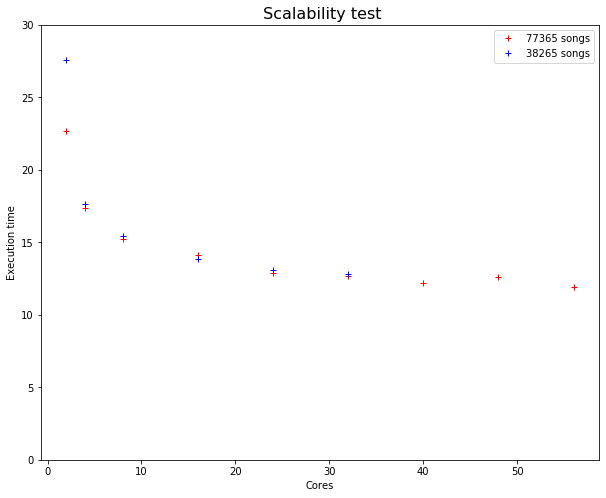

In [37]:
values_2 = [22.67, 17.35 , 15.2 , 14.16, 12.87, 12.67, 12.20, 12.59, 11.94] 
values_1 = [27.58, 17.68, 15.46, 13.83, 13.12, 12.8]
cores = [2, 4, 8, 16, 24, 32, 40, 48, 56]
plt.figure(figsize=(10,8))
plt.plot(cores, values_2, 'r+', label = "77365 songs")
plt.plot(cores[:6], values_1, 'b+', label = "38265 songs")
plt.ylim(0,30)
plt.xlabel("Cores")
plt.ylabel("Execution time")
plt.legend()
plt.title(" Scalability test", {"fontsize":16})
plt.show()